# Sorting and Measuring Wave Activity from Short-Time Fourier Transform PSP Magnetic Field Data Algorithmically
We are looking for wave activity that have the following properties:
* coherent (i.e. in phase, non random fluctuations)
* low wave normal angle (i.e. the wave vector is close to parallel to the background magnetic field)
* circularly polarized (can be either left handed or right handed)

In [1]:
# inputs: WaveAnalysis file, filter levels (coherency, circular polarization, wave normal angle, median filter smoothing)
# parameters to extract: wave power, coherency, ellipticity, wave normal angle, frequencies, epoch
# outputs: write epoch and integrated wave power, median coherency/ellipticity/wave normal angle at the cadence of the file for rh and lh circularly polarized data
# have option to plot (and return fig,ax) the original vs filtered coherency and wave normal angle plot

# Functions

In [2]:
import wget
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from datetime import date, timedelta
from datetime import datetime
import bisect
import warnings
warnings.filterwarnings("ignore")
import spacepy.plot as splot
from cycler import cycler
from scipy import interpolate
import spacepy
import matplotlib.dates as mdates
import cdflib
import pandas as pd
from scipy import ndimage
import pytz
# import pickle
import matplotlib.ticker as tck
from spacepy import pycdf 
# import pylops

utc = pytz.utc

In [3]:
def synchronize(epoch_lowCadence,epoch_highCadence,parameter_highCadence,combine=False,int_type='linear',angle=False):
    '''
    Synchronizes two cdf datasets of different cadence using numpy linear interpolation and returns the interpolated array
    for the high cadence parameter at the cadence of the low cadence dataset
    
    Parameters:
    -------------------
    epoch_lowCadence: the epoch of the low cadence dataset which is in an array with datetime elements
    epoch_highCadence: the epoch of the high cadence (i.e. sampled at a higher frequency) dataset which is an an array of datetime elements
    parameter_highCadence: the data array for the parameter with high cadence associated with the epoch_highCadence
    combine: (Default: False) If true, then the interpolated arrays are concatenated
    
    Returns:
    parameters_interpolation: a list containing the interpolated arrays for each parameter (i.e. column of parameter_highCadence) given. Each
        entry has a length equal to the size of epoch_lowCadence
    
        If combine is true then the list is concatenated along columns into one large array with row # equal to the size of epoch_lowCadence
        and column # equal to the column # of parameter_highCadence
    -------------------
    
    '''
    try:
        epoch_lowCadence_sec = [(i-epoch_lowCadence[0]).total_seconds() for i in epoch_lowCadence] 
    except:
        epoch_lowCadence_sec = [(i-epoch_lowCadence[0])/np.timedelta64(1, 's') for i in epoch_lowCadence] # in the event we're using np.datetime64 dtype
    # converts epoch_lowCadence datetime array into an array with the seconds elapsed since the starting date of epoch_lowCadence
    
    try:
        epoch_highCadence_sec = [(i-epoch_lowCadence[0]).total_seconds() for i in epoch_highCadence] 
    except:
        epoch_highCadence_sec = [(i-epoch_lowCadence[0])/np.timedelta64(1,'s') for i in epoch_highCadence] 

    print(epoch_highCadence_sec[-1],epoch_lowCadence_sec[-1])
    # converts epoch_highCadence datetime array into an array with the seconds elapse since the starting date of epoch_lowCadence.
    # We use the starting date of epoch_lowCadence as reference for both arrays so that the highCadence time array is in reference
    # to the seconds elapsed since the same starting date and are comparable. 
    # If we used a difference starting date for each epoch array, this would make influence the time difference between events and
    # the interpolation would be not truly be synchronizing the arrays
    
    try: 
        parameter_num = parameter_highCadence.shape[1] # extracts the number of columns for our parameter array indicating
    except:
        parameter_num = 1
    # the number of parameters we want to interpolate. We do each interpolation separately (i.e. 1D interp)
    
    
    if int_type == 'linear':
        if not angle:
            
            if parameter_num == 1:
                parameters_interpolation = np.interp(epoch_lowCadence_sec,epoch_highCadence_sec, parameter_highCadence)
                combine = False
            else:
                parameters_interpolation = [] # our output list containing the interpolated arrays for each parameter given
                for i in range(0,parameter_num):
                    parameters_interpolation.append(np.interp(epoch_lowCadence_sec,epoch_highCadence_sec, parameter_highCadence[:,i]))
        else:
            if parameter_num == 1:

                #unwrap the angle in degrees parameter
                complement360 = np.rad2deg(np.unwrap(np.deg2rad(parameter_highCadence)))
                
                parameters_interpolation = np.interp(epoch_lowCadence_sec,epoch_highCadence_sec, complement360)
                parameters_interpolation = parameters_interpolation%360 #use mod to wrap angle parameter again
                
                combine = False
            else:
                parameters_interpolation = [] # our output list containing the interpolated arrays for each parameter given
                for i in range(0,parameter_num):
                    complement360 = np.rad2deg(np.unwrap(np.deg2rad(parameter_highCadence)))
                
                    parameter_interpolation = np.interp(epoch_lowCadence_sec,epoch_highCadence_sec, complement360)
                    parameter_interpolation = parameters_interpolation%360 #use mod to wrap angle parameter again
                
                    
                    parameters_interpolation.append(parameter_interpolation)
    else:
        if parameter_num == 1:
            f = interpolate.interp1d(epoch_highCadence_sec, parameter_highCadence,kind=int_type)
            parameters_interpolation = f(epoch_lowCadence_sec)
            combine = False
        else:
            parameters_interpolation = [] # our output list containing the interpolated arrays for each parameter given
            for i in range(0,parameter_num):
                f = interpolate.interp1d(epoch_highCadence_sec, parameter_highCadence[:,i],kind=int_type)
                parameters_interpolation.append(f(epoch_lowCadence_sec))
    
    
    if combine == True:
        # first check the shapes of the arrays are the same and make sure each entry is a column vector
        for i in range(0,parameter_num):
            try:
                parameters_interpolation[i].shape[1]
            except:
                parameters_interpolation[i] = np.array(parameters_interpolation[i],ndmin=2)
                
            if parameters_interpolation[i].shape[1] > parameters_interpolation[i].shape[0]:
                parameters_interpolation[i] = np.transpose(parameters_interpolation[i])
        
        # combine column vectors
        parameters_interpolation  = np.concatenate(tuple(parameters_interpolation),axis=1)  

    return parameters_interpolation

In [4]:
def tz_check(date):
    utc=pytz.UTC
    if not (date.tzinfo is not None and date.tzinfo.utcoffset(date) is not None):
        date = utc.localize(date)
        return date
    else:
        return date     

In [5]:
def tt2000_toDatetime64(epoch_ns):
    
    datetime_array = cdflib.cdfepoch.breakdown_tt2000(epoch_ns)
    epoch = []
    for i in range(0,datetime_array.shape[0]):
        time_components = datetime_array[i,:] #extracting the time components (year, month, day, hour, minute, second, millisecond, microsecond, nanosecond).

        # Creating a string representation of the time
        time_string = f"{time_components[0]:04d}-{time_components[1]:02d}-{time_components[2]:02d}T{time_components[3]:02d}:{time_components[4]:02d}:{time_components[5]:02d}.{time_components[6]:03d}{time_components[7]:03d}{time_components[8]:03d}Z"
        # converts to the format YYYY-MM-DDTHH:mm:ss.ssssssZ where T indicates the delimiter between date and time and Z indicates Zulu Time (i.e. UTC)

        # Converting the time string to a numpy datetime64 object
        epoch.append(np.datetime64(time_string))

    return np.array(epoch)

In [6]:
def import_singleWaveAnalysis(filedate,parameter_list,version='1.2',datetime_convert=False,fileDirectory='./',verbose=False):
    '''
    Reads in all the Kristoff's Wave Analysis cdf files of the form: remoteDirectory/PSP_WaveAnalysis_{day.year}-{day.strftime("%m")}-{day.strftime("%d")}_{day.strftime("%H%M")}_v{version}.cdf
    between the given start and end dates (including the start/end dates) without using pycdf 
    
    
    Parameters:
    --------------------
    fileDirectory: URL or filepath to the directory containing the files
    filedate: date in datetime. Requires month, day, year, and hour. The files come in four different starting hours: 0000, 0600, 1200, and 1800. 
                The code will round to the nearest 6th hour if a different hour is given.
    parameter_list: a list containing the string names of the variables of interest that you want to extract
        Ex: ['np_moment','vp_moment'] if you want to extract the proton number density and velocity moments from the cdf
    version: the version of wave analysis files as a string
    verbose: (default false) when True it prints out more contextual information as function runs
    
    Returns:
    --------------------
    file_cdf: a list containing the cdf of each file in cdflib format.
    parameters_cdf: the numpy data array associated with each parameter in parameter list. 
    parameters_epoch: the epoch dependency associated with each parameter in the parameter list.
    '''
    utc=pytz.UTC
    epoch_localize=np.vectorize(utc.localize)

    #make start and end dates aware
    filedate = tz_check(filedate)

    # if frequency is a parameter, move it to the end of the list. This is helpful for plotting as frequency is a dependency
    if 'Frequencies' in parameter_list:
        parameter_list.remove('Frequencies')
        parameter_list.append('Frequencies')
    
    closest_6hr = int(np.floor(filedate.hour/6)*6)%24
    start_6hr = datetime(filedate.year,filedate.month,filedate.day,closest_6hr)
    
    # By using "fstrings" we can easily substitute variables into the filename
    remoteFilename = f'PSP_WaveAnalysis_{start_6hr.year}-{start_6hr.strftime("%m")}-{start_6hr.strftime("%d")}_{start_6hr.strftime("%H%M")}_v{version}.cdf'
    
    if verbose:
        print(remoteFilename)

    file = fileDirectory+remoteFilename
    if os.path.isfile(file):
        if verbose:
            print ("File exists already")
    else:
        raise Exception(f"\nFile {file} not found locally")
        
    cdflib_cdf = cdflib.CDF(file) # we use this to actually extract the data

    
    
    files_cdflib = []
    parameters_epoch = []
    parameters_array = []
    
    file_cdflib = cdflib_cdf
    
    for parameter in parameter_list:
        
        parameter_array = cdflib_cdf.varget(parameter)
        try:
            parameter_array  = np.where(parameter_array==cdflib_cdf.attget('FILLVAL',parameter).Data[0], np.nan, parameter_array) # replace fill values with nan
        except:
            print(f'no FILLVAL attribute found for {parameter}')
        parameters_array.append(parameter_array)
        
        # some parameters don't have epochs
        try:
            parameter_epoch = cdflib_cdf.varget(cdflib_cdf.attget('DEPEND_0',parameter).Data)
            parameter_epoch = tt2000_toDatetime64(parameter_epoch) # convert tt2000 time into a numpy datetime64 dtype
            # note that you should use timedelta64 when determining time differences with this datatype.
            
            if datetime_convert:
                series = pd.Series(parameter_epoch) # Convert pandas Series to standard datetime array
                parameter_epoch = pd.to_datetime(series).dt.to_pydatetime()
            parameter_epoch = epoch_localize(parameter_epoch)
        except:
            if verbose:
                print(parameter+' does not have an associated epoch')
            parameter_epoch = None # if a parameter does not have an epoch dependency, we return none for epoch
     
        parameters_epoch.append(parameter_epoch)
        
    return file_cdflib,parameters_array,parameters_epoch

In [7]:
def import_waveAnalysis(start_date,end_date,parameter_list,version='1.2',datetime_convert=False,fileDirectory='./'):
    '''
    Reads in Kristoff's Wave Analysis cdf files of the form: remoteDirectory/PSP_WaveAnalysis_{day.year}-{day.strftime("%m")}-{day.strftime("%d")}_{day.strftime("%H%M")}_v{version}.cdf
    between the given start and end dates (including the start/end dates) without using pycdf 
    V.V refers to version number
    
    
    Parameters:
    --------------------
    remoteDirectory: URL to the directory containing the files
    remoteFileBase: The base naming scheme of the file name before the date
    remoteFilenameFooter: The footer naming scheme of the file name. Typically this is the version given in the form vXX
        where XX indicates the version number. For instance, vesion 2 would be v02.
    start_date: input the start date for data as a datetime object
    end_date: input the end date for data as a datetime object
    parameter_list: a list containing the string names of the variables of interest that you want to extract
        Ex: ['np_moment','vp_moment'] if you want to extract the proton number density and velocity moments from the cdf
    
    Returns:
    --------------------
    files_cdf: a list containing the cdf of each file in cdflib format.
    parameters_cdf: a list containing the numpy data array associated with each parameter in parameter list. 
        To access the cdf for the parameter at index 1 in parameter list use parameters_array[1]
    parameters_epoch: the list containing the epoch dependency associated with each parameter in the parameter list.
    '''

    utc=pytz.UTC
    epoch_localize=np.vectorize(utc.localize)

    #make start and end dates aware
    start_date = tz_check(start_date)
    end_date = tz_check(end_date)

    # if frequency is a parameter, move it to the end of the list. This is helpful for plotting as frequency is a dependency
    if 'Frequencies' in parameter_list:
        parameter_list.remove('Frequencies')
        parameter_list.append('Frequencies')
    
    closest_6hr = int(np.floor(start_date.hour/6)*6)%24
    last_6hr = int(np.floor((end_date.hour)/6)*6)%24
    start_6hr = datetime(start_date.year,start_date.month,start_date.day,closest_6hr)
    end_6hr = datetime(end_date.year,end_date.month,end_date.day,last_6hr)
    delta = end_6hr-start_6hr    

    # obtains all the dates between the first 6 hour date and last 6 hour date that contains the start/end dates.
    # by 6 hour date I mean a date of the form YYYYMMDD_HHMM where HHMM is either 0000, 06000, 1200, or 1800
    dates = [start_6hr + timedelta(hours=6*i) for i in range(int((delta.total_seconds())/3600/6)+1)]

    print(dates)
    
    firstTime = True
    for day in dates:
        # By using "fstrings" we can easily substitute variables into the filename
        remoteFilename = f'PSP_WaveAnalysis_{day.year}-{day.strftime("%m")}-{day.strftime("%d")}_{day.strftime("%H%M")}_v{version}.cdf'
        
        print(remoteFilename)

        file = fileDirectory+remoteFilename
        if os.path.isfile(file):
            print ("File exists already")
        else:
            raise Exception(f"\nFile {file} not found locally")
            
        cdflib_cdf = cdflib.CDF(file) # we use this to actually extract the data

        
        if firstTime==True:
            files_cdflib = []
            parameters_epoch = []
            parameters_array = []
            
            files_cdflib.append(cdflib_cdf)
            
            for parameter in parameter_list:
                
                parameter_array = cdflib_cdf.varget(parameter)
                try:
                    parameter_array  = np.where(parameter_array==cdflib_cdf.attget('FILLVAL',parameter).Data[0], np.nan, parameter_array) # replace fill values with nan
                except:
                    print(f'no FILLVAL attribute found for {parameter}')
                parameters_array.append(parameter_array)
                
                # some parameters don't have epochs
                try:
                    parameter_epoch = cdflib_cdf.varget(cdflib_cdf.attget('DEPEND_0',parameter).Data)
                    parameter_epoch = tt2000_toDatetime64(parameter_epoch) # convert tt2000 time into a numpy datetime64 dtype
                    # note that you should use timedelta64 when determining time differences with this datatype.
                    
                    if datetime_convert:
                        series = pd.Series(parameter_epoch) # Convert pandas Series to standard datetime array
                        parameter_epoch = pd.to_datetime(series).dt.to_pydatetime()
                    parameter_epoch = epoch_localize(parameter_epoch)
                except:
                    print(parameter+' does not have an associated epoch')
                    parameter_epoch = None # if a parameter does not have an epoch dependency, we return none for epoch
             
                parameters_epoch.append(parameter_epoch)
                
                
            firstTime = False
            
        elif firstTime==False:
            
            files_cdflib.append(cdflib_cdf)
            for i in range(0,len(parameter_list)):
                
                parameter_array = cdflib_cdf.varget(parameter_list[i])
                try:
                    parameter_array  = np.where(parameter_array==cdflib_cdf.attget('FILLVAL',parameter_list[i]).Data[0], np.nan, parameter_array) # replace fill values with nan
                except:
                    print(f'no FILLVAL attribute found for {parameter_list[i]}')

                try:
                    parameter_epoch = cdflib_cdf.varget(cdflib_cdf.attget('DEPEND_0',parameter_list[i]).Data)
                    parameter_epoch = tt2000_toDatetime64(parameter_epoch) # convert tt2000 time into a numpy datetime64 dtype
                    # note that you should use timedelta64 when determining time differences with this datatype.
                    
                    if datetime_convert:
                        series = pd.Series(parameter_epoch) # Convert pandas Series to standard datetime array
                        parameter_epoch = pd.to_datetime(series).dt.to_pydatetime()
                    
                    parameters_epoch[i]  = np.concatenate( (parameters_epoch[i] ,  epoch_localize(parameter_epoch)) ,  axis=0)
                except:
                    print(parameter_list[i]+' does not have an associated epoch')
                    parameter_epoch = None # if a parameter does not have an epoch dependency, we return none for epoch
                    parameters_epoch[i]  = None
                
                parameters_array[i]  = np.concatenate( (parameters_array[i] ,  parameter_array) ,  axis=0)
                
    # save the data only in the start and end date range
    for i in range(0,len(parameter_list)):
        try:
            startIndex = bisect.bisect_left(parameters_epoch[i], start_date)
            stopIndex  = bisect.bisect_left(parameters_epoch[i], end_date)
            parameters_array[i] = parameters_array[i][startIndex:stopIndex] #extracts the relevant data
            parameters_epoch[i] = parameters_epoch[i][startIndex:stopIndex]
            print(f'{parameter_list[i]} adjusted')
        except:
            pass
        
    return files_cdflib,parameters_array,parameters_epoch

In [8]:
def filter_activity(wave_parameters,parameter_names,frequencyAxis,coherency_filter=0.8,circPol_filter=0.5,waveNormAngle_filter=45,filter_size=10,trim=1.5,plot=False,verbose=False):
    
    if ('wave_normal_b' not in parameter_names) and ('kz_b' not in parameter_names):
        raise ValueError('Need wave_normal_b parameter to filter out high normal angles')
    if 'coherency_b' not in parameter_names:
        raise ValueError('Need coherency_b parameter to filter out incoherency')

    frequencyBinWidth = frequencyAxis[1]-frequencyAxis[0]
    
    try:
        coherency_waveNorm_condition = (ndimage.median_filter(wave_parameters[parameter_names.index('coherency_b')],size=filter_size)<coherency_filter) | (ndimage.median_filter(wave_parameters[parameter_names.index('wave_normal_b')],size=filter_size)>waveNormAngle_filter)
    except:
        coherency_waveNorm_condition = (ndimage.median_filter(wave_parameters[parameter_names.index('coherency_b')],size=filter_size)<coherency_filter) | (ndimage.median_filter(wave_parameters[parameter_names.index('kz_b')],size=filter_size)>waveNormAngle_filter)
    
    if verbose:    
        print(f'Filtering out incoherent high normal angle data that falls below a coherency of {coherency_filter} and above wave normal angle of {waveNormAngle_filter} deg')
    
    for i in range(0,len(wave_parameters)):
        wave_parameters[i] = np.where(coherency_waveNorm_condition,np.nan,wave_parameters[i])

    

    # ellipticity filtering out linear polarization and sorting into right handed and left handed
    circPol_condition = np.abs(ndimage.median_filter(wave_parameters[parameter_names.index('ellipticity_b')],size=filter_size))>= circPol_filter
    right_hand_condition = ndimage.median_filter(wave_parameters[parameter_names.index('ellipticity_b')],size=filter_size)>= circPol_filter
    left_hand_condition = ndimage.median_filter(wave_parameters[parameter_names.index('ellipticity_b')],size=filter_size)<= -1*circPol_filter

    if verbose:
        print(f'Filtering out linear polarization below ellipticity of {circPol_filter} and sorting into rh and lh circular polarization')

    for i in range(0,len(wave_parameters)):
        wave_parameters[i] = np.where(circPol_condition,wave_parameters[i],np.nan)

    # trim top and bottom frequency bins to remove edge effects. If trim is < 0 then no trim is applied.
    if trim>0:
        if verbose:
            print(f'Trimming top and bottom frequencies by {trim} Hz')
        frequency_Trim = np.repeat(np.array((frequencyAxis < np.ceil(np.max(frequencyAxis))-trim) & (frequencyAxis > np.floor(np.min(frequencyAxis))+trim),dtype=bool,ndmin=2),wave_parameters[0].shape[0],axis=0)
        for i in range(0,len(wave_parameters)):
            wave_parameters[i] = np.where(frequency_Trim,wave_parameters[i],np.nan)

    rh_data=[]; lh_data=[];
    for i in range(0,len(wave_parameters)):
        rh_data.append(np.where(right_hand_condition,wave_parameters[i],np.nan))
        lh_data.append(np.where(left_hand_condition,wave_parameters[i],np.nan))

    # the data has no been filtered to extract high coherency and low wave normal activity, trimmed in the top/bottom frequency bins, 
    # and sorted into rh circ pol and lh circ pol. We now want to sum the wave parameters along the frequency axis and multiply by the frequency bin width
    # this amounts to a midpoint Reimann sum approximation of the integral
    rh_integrated_data = []
    lh_integrated_data = []
    for i in range(0,len(wave_parameters)):
        if parameter_names[i] is 'Wave_Power_b':
            rh_integrated_data.append(np.nansum(rh_data[i],axis=1)*frequencyBinWidth)
            lh_integrated_data.append(np.nansum(lh_data[i],axis=1)*frequencyBinWidth)
        else:
            rh_integrated_data.append(np.nanmedian(rh_data[i],axis=1))
            lh_integrated_data.append(np.nanmedian(lh_data[i],axis=1))

    df = pd.DataFrame(data = [lh_integrated_data[0],rh_integrated_data[0],lh_integrated_data[1],rh_integrated_data[1],lh_integrated_data[2],rh_integrated_data[2],lh_integrated_data[3],rh_integrated_data[3]]).T
    df.columns=['lh integrated wave power (nT^2)','rh integrated wave power(nT^2)','lh med ellipticity','rh med ellipticity','lh med coherency','rh med coherency','lh med wave normal angle','rh med wave normal angle']

    return df,wave_parameters

In [ ]:
plt.pcolormesh(shading=

In [9]:
def plot_waveActivity(start,end,parameters,data,epoch,frequencyAxis,
                      parameter_limits,parameter_log,parameter_cmap,parameter_units,
                        restrict_ylim=False,log_freq=False,
                     save=False,pkl=False,show=True,title='PSP B-field Wave Parameters',output_fileBase='waveParameters',
                     verbose=False):
    utc=pytz.UTC
    epoch_localize=np.vectorize(utc.localize)
    start = tz_check(start)
    end = tz_check(end)
    
    if verbose:
        print('start of time period:',start.strftime('%m/%d/%y %H:%M'))
        print('end of time period:',end.strftime('%m/%d/%y %H:%M'))


    startIndex = np.searchsorted(epoch, start)
    stopIndex  = np.searchsorted(epoch, end)
    
    x_lims = mdates.date2num([epoch[startIndex],epoch[stopIndex-1]])
    # print(epoch[0],epoch[startIndex],epoch[stopIndex-1])

    n = len(parameters)
    

    fig, ax = plt.subplots(n,1,sharex=True,constrained_layout=True)
    fig.set_size_inches(14,2*n)

    
    X, Y = np.meshgrid(epoch[startIndex:stopIndex], frequencyAxis)
    fAxis_min = frequencyAxis.min()
    fAxis_max = frequencyAxis.max()
    for i in range(0,n):
        plot_index = i
        
        if parameter_log[i]:

            if parameter_limits[i] == None: #if None on parameter limits, then we don't set colorbar limits

                pcm = ax[plot_index].pcolormesh(X, Y, np.transpose(data[i]), cmap=parameter_cmap[i],
                                                norm=colors.LogNorm(),shading='nearest')  
            elif (parameter_limits[i][0] != 0): #LogNorm struggles when we set vmin to 0
               
                pcm = ax[plot_index].pcolormesh(X, Y, np.transpose(data[i]), cmap=parameter_cmap[i],
                                                norm=colors.LogNorm(vmin = parameter_limits[i][0],vmax  =  parameter_limits[i][1]),shading='nearest')  
            else:
                
                pcm = ax[plot_index].pcolormesh(X, Y, np.transpose(data[i]), cmap=parameter_cmap[i],
                                                norm=colors.LogNorm(vmax  =  parameter_limits[i][1]),shading='nearest')
        else:
           
            pcm = ax[plot_index].pcolormesh(X, Y, np.transpose(data[i]), cmap=parameter_cmap[i],
                                            vmin  =  parameter_limits[i][0], vmax  =  parameter_limits[i][1],
                                            shading='nearest')  
        
        if log_freq:
            ax[plot_index].set_yscale('log')
            ax[plot_index].set_ylim([0.5,32])
            
        ax[plot_index].xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax[plot_index].xaxis.set_major_formatter(date_format)
        splot.applySmartTimeTicks(ax[plot_index], epoch[startIndex:stopIndex], dolimit=False, dolabel=False)
        ax[plot_index].grid(False) # turns off grid
        ax[plot_index].yaxis.set_minor_locator(tck.AutoMinorLocator()) #turns on minor ticks
        # cbar = fig.colorbar(im)#,cax = colorbar_axes)
        cbar = fig.colorbar(pcm)
        cbar.ax.set_ylabel(f'{parameters[i]}\n${{{parameter_units[i]}}}$',rotation=270,labelpad=35)
        
        plt.subplots_adjust(right=0.85)
        if restrict_ylim:
            ax[plot_index].set_ylim([0,32]) #make sure we limit yaxis to 0 to 32 Hz, some data may be from 0 to 150 Hz
        if plot_index == n-1:
#             ax[plot_index].set_xlabel(f'Encounter {encounter}, Interval {interval}: {start.strftime("%Y-%m-%d %H:%M")} -- {end.strftime("%Y-%m-%d %H:%M")} (UT)')
            ax[plot_index].set_xlabel(f'{start.strftime("%Y-%m-%d %H:%M")} -- {end.strftime("%Y-%m-%d %H:%M")} (UT)')            

        
        if plot_index == 0:
            ax[plot_index].set_title(f'{title}', fontsize=12)                                      
        if plot_index == 0:
            ax[plot_index].set_ylabel('Frequency (Hz)')
        
        
        ax[plot_index].tick_params(axis="y",
                    which="minor",
                    length=8,
                    direction='out')  
        plt.tick_params()
        ax[plot_index].tick_params(axis="y",
                        which="major",
                        length=10,
                        direction='out')
        ax[plot_index].tick_params(axis="x",
                    which="minor",
                    length=8,
                    direction='out')  
        ax[plot_index].tick_params(axis="x",
                        which="major",
                        length=10,
                        direction='out')

    # fig.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0.1)
   
                                      
    if pkl:
        filename = f"{output_fileBase}_{start.strftime('%Y-%m-%d_%H%M')}__{end.strftime('%Y-%m-%d_%H%M')}"
        if log_freq:
            filename = filename + "_logFreq"
        filename = filename + ".fig.pkl"

        pickle.dump([fig,ax], open(filename, 'wb'))
        # use pickle.load(open("waveParameters_{start.strftime('%Y-%m-%d_%H%M')}__{end.strftime('%Y-%m-%d_%H%M')}.fig.pkl",'rb')) to load in figure
    if save:
        filename = f"{output_fileBase}_{start.strftime('%Y-%m-%d_%H%M')}__{end.strftime('%Y-%m-%d_%H%M')}"
        if log_freq:
            filename = filename + "_logFreq"
        filename = filename + ".png"
                                      
        fig.savefig(filename,dpi=300)
    
    if show:
        plt.show()
    else:
        plt.close()                                      
                                      
    return fig, ax

In [10]:
def datetime_to_tt2000(epoch):
    '''
    Converts datetime (with precision up to microseconds) to CDF_tt2000 datatype
    Inputs: list or array of dates in datetime
    Output: numpy array of dates in tt2000 dtype
    '''
    epoch_str = [list(map(int, (date.strftime('%Y,%m,%d,%H,%M,%S,%f')[:-3]+','+date.strftime('%Y,%m,%d,%H,%M,%S,%f')[-3:]).split(','))) for date in epoch]
    return cdflib.cdfepoch.compute_tt2000(epoch_str)
    # return compute_tt2000_array(epoch_str)
def datetime_to_cdfepoch(epoch):
    '''
    Converts datetime (with precision up to microseconds) to CDF_epoch dtype
    Inputs: list or array of dates in datetime
    Output: numpy array of dates in CDF epoch dtype
    '''
    epoch_str = [list(map(int, (date.strftime('%Y,%m,%d,%H,%M,%S,%f')[:-3]+','+date.strftime('%Y,%m,%d,%H,%M,%S,%f')[-3:]).split(','))) for date in epoch]
    
    return cdflib.cdfepoch.compute_epoch(epoch_str)

def cdfepoch_to_datetime(epoch):
    '''
    Converts CDF_epoch dtype to datetime (with precision up to milliseconds)
    Inputs: list or array of dates in cdf_epoch dtype
    Output: list of dates in datetime dtype
    '''
    date_list = cdflib.cdfepoch.breakdown_epoch(epoch)      
    # #adjusts the milliseconds element of the date array to contain 6 digits that include milli and microseconds
    # # datetime will ignore additional elements so we don't need to change the original microseconds element.
    return [datetime(*date) for date in date_list]


# Algorithm

In [21]:
def extract_activity(start_date,end_date,coherency_filter=0.8,circPol_filter=0.5,waveNormAngle_filter=45,filter_size=10,trim=1.5,
                     version='1.2',fileDirectory='./',plot_show=False,plot_save=False,
                     verbose=False,unix_output=False,skip_existing=True):
    '''
    Extracts the coherent, circularly polarized, low wave normal angle wave activity and calculates the integrated wave power across frequency space at the cadence of the input WaveAnalysisFiles.
    --------
    Inputs:
    --------
    start_date  :  starting date to look for WaveAnalysis files in datetime (assumes utc timezone)
    
    end_date  :  end date for WaveAnalysis files in datetime (assumes utc timezone). Looks for dates up until the file that includes the end date.
    
    coherency_filter  :  (default 0.8) wave activity below this limit (through a top hat median approach) are removed. Can range from 0 to 1
    
    circPol_filter  :  (default 0.5) |ellipticity| data below this limit (through a top hat median approach) are removed. Can range from 0 to 1
    
    waveNormAngle_filter  :  (default 45) wave normal angle data (in degrees) above this limit are removed. Can range from 0 to 90
    
    filter_size  :  (default 10) the footprint used for the top hat filter. If you want an asymmetric footprint (look at more neighbors in one axis versus the other) input an integer tuple (rows,cols).
    
    trim  :  (default 1.5) masks the data in rows corresponding to frequencies such that f > ceil(max(frequency)) - trim and f < floor(min(frequency) + trim (the values are assumed to be in Hz) to remove edge defects
    
    version  :  (default '1.2') the version of WaveAnalysis files being imported
    
    fileDirectory  :  (default './') the directory where the WaveAnalysis files are stored
    
    plot_show  :  (default False) outputs 2 plots every 5 files (starting on the first file): one of the extracted activity and one for the original activity
    
    plot_save  :  (default False) saves 2 plots every 5 files (starting on the first file): one of the extracted activity and one for the original activity
    
    verbose  :  (default False) If true, outputs more contextual information
    
    unix_output  :  (default False) If true, output text file uses unix time for the time column. If false, uses cdf epoch (with only millisecond precision).
    
    skip_existing  :  (default True) If true, skips files in which filteredActivity txt file already exists
    
    ---------
    Outputs: 
    ---------
    Writes the integrated wave power and median wave parameter statistics (coherency/ellipticity/wave norm angle) of wave activity (split into left and right hand circular polarization) to a csv file of the form: 
    fileDirectory+f"filteredActivity_{filedate.strftime('%Y-%m-%d_%H%M')}.txt
    
    '''
    

    
    #make start and end dates timezone aware
    start_date = tz_check(start_date)
    end_date = tz_check(end_date)
    
    closest_6hr = int(np.floor(start_date.hour/6)*6)%24
    last_6hr = int(np.floor((end_date.hour)/6)*6)%24
    start_6hr = datetime(start_date.year,start_date.month,start_date.day,closest_6hr)
    end_6hr = datetime(end_date.year,end_date.month,end_date.day,last_6hr)
    delta = end_6hr-start_6hr    

    # obtains all the dates between the first 6 hour date and last 6 hour date that contains the start/end dates.
    # by 6 hour date I mean a date of the form YYYYMMDD_HHMM where HHMM is either 0000, 06000, 1200, or 1800
    dates = [start_6hr + timedelta(hours=6*i) for i in range(int((delta.total_seconds())/3600/6)+1)]
    if len(dates) == 1:
        print(f"Searching for 6 hr file starting on {dates[0].strftime('%Y-%m-%d_%H%M')}")
    else:
        print(f"Searching for 6 hr files from {dates[0].strftime('%Y-%m-%d_%H%M')} to {dates[-1].strftime('%Y-%m-%d_%H%M')}")
    
    if version is '1.2':
        # this version incorrectly calculates the wave_normal angle so we must calculate it from kz_b
        parameters_list = ['Wave_Power_b','ellipticity_b','coherency_b','kz_b','Frequencies']
    else:
        parameters_list = ['Wave_Power_b','ellipticity_b','coherency_b','wave_normal_b','Frequencies']
    i=0
    for date in dates:

        if skip_existing:
            if os.path.isfile(fileDirectory+f"filteredActivity_{date.strftime('%Y-%m-%d_%H%M')}.txt"):
                print(f"txt file already exists for {date.strftime('%Y-%m-%d_%H%M')}; skipping")
                continue
            
            
        
        # check if txt file exists

        
        try: 
            filecdf,wave_data,epochs = import_singleWaveAnalysis(date,parameters_list,version = version,datetime_convert=True,
                                                     fileDirectory=fileDirectory,verbose=verbose)
        except:
            print(f"Unable to find file for {date.strftime('%Y-%m-%d_%H%M')}, version v{version}")
            continue
        #wave_data[-1] is the frequencyAxis
        if version is '1.2':
            wave_data[-2] = np.arccos(wave_data[-2]) * 180/np.pi 
        
        filter_df,wave_data_filtered = filter_activity(wave_data[:-1],parameters_list[:-1],wave_data[-1],
                                                        coherency_filter=coherency_filter,circPol_filter=circPol_filter,waveNormAngle_filter=waveNormAngle_filter,filter_size=filter_size,trim=trim,
                                                      verbose=verbose)

        
        # every fifth file plot wave_parameters
        if i%5 == 0 and (plot_show or plot_save):
    
            parameter_limits = [
                                [2e-3,1e2],
                                [filecdf.attget('VALIDMIN',parameters_list[1]).Data,filecdf.attget('VALIDMAX',parameters_list[1]).Data], 
                                [0,1],
                                [0,90]
                               ] 
            parameter_log = [True,False,False,False]
            parameter_cmap = ['plasma','bwr','binary','binary']
            parameter_units = [filecdf.attget('UNITS',param).Data for param in parameters_list[:-1]]
            parameter_units[0] = '(nT^2/Hz)' # wave power units
            parameter_units[3] = '(deg)'
    
            
            fig,ax = plot_waveActivity(date,date + timedelta(hours=6),parameters_list[:-1],wave_data_filtered,epochs[1],wave_data[-1],
                               parameter_limits,parameter_log,parameter_cmap,parameter_units,
                                       show=plot_show,save=plot_save,
                                       title=f'Filtered Wave Activity: c>{coherency_filter}, |ϵ|>{circPol_filter}, θ<{waveNormAngle_filter} deg',
                                       output_fileBase='filteredParameters',verbose=verbose
                              )
            if plot_show:
                plt.show()
    
            fig,ax = plot_waveActivity(date,date + timedelta(hours=6),parameters_list[:-1],wave_data[:-1],epochs[1],wave_data[-1],
                               parameter_limits,parameter_log,parameter_cmap,parameter_units,
                                       show=plot_show,save=plot_save,
                                       title=f'Original Wave Parameters',
                                       output_fileBase='originalParameters',verbose=verbose
                              )
            if plot_show:
                plt.show()
        i+=1
        
        # assemble the wave activity data into a pandas dataframe and write to text file
        # seconds_elapsed_epoch = np.array([(epochs[1][i]-epochs[1][0]).total_seconds() for i in range(0,len(epochs[1]))],dtype=np.float64) # seconds elapsed since the start date of the file.
        if unix_output:
            unix_time = [date.replace(tzinfo=utc).timestamp() for date in epochs[1]] #Unix time (aka) seconds elapsed since January 1st 1970
            filter_df.insert(0,'unix time (s)',unix_time,False)

        else:
            cdfepoch = datetime_to_cdfepoch(epochs[1])
            filter_df.insert(0,'cdf epoch',cdfepoch,False)
            
        if i%3 == 0:
            print(f"writing {date.strftime('%Y-%m-%d_%H%M')} filtered activity to txt")
        filter_df.to_csv(fileDirectory+f"filteredActivity_{date.strftime('%Y-%m-%d_%H%M')}.txt", header=None, index=None) #should I add something to indicate filter information
        
    return

In [84]:
plt.close('all')
# enc10_start = tz_check(datetime(2021,11,16,0,0)) # enc10
# enc10_end = tz_check(datetime(2021,11,26,23,59))
enc10_start = tz_check(datetime(2021,11,22,0,0)) # enc10
enc10_end = tz_check(datetime(2021,11,23,19,0))
# enc11_start = tz_check(datetime(2022,2,20,0,0)) #enc11
# enc11_end = tz_check(datetime(2022,3,2,19,0))
# enc13_start = tz_check(datetime(2022,9,1,0,0)) #enc13
# enc13_end = tz_check(datetime(2022,9,11,19,0))
# enc14_start = tz_check(datetime(2022,12,6,0,0)) #enc14
# enc14_end = tz_check(datetime(2022,12,16,19,0))
# enc15_start = tz_check(datetime(2023,3,12,0,0)) #enc15 (a lot of files were missing)
# enc15_end = tz_check(datetime(2023,3,23,19,0))
# enc16_start = tz_check(datetime(2023,6,16,0,0)) #enc16
# enc16_end = tz_check(datetime(2023,6,27,19,0))
# enc17_start = tz_check(datetime(2023,9,22,0,0)) #enc17
# enc17_end = tz_check(datetime(2023,10,3,19,0))

extract_activity(enc10_start,enc10_end,fileDirectory='/Users/nandroski/Desktop/CalPoly/SeniorProject/SAO/Data/',plot_save=True,version='1.3',skip_existing=False)

Searching for 6 hr files from 2021-11-22_0000 to 2021-11-23_1800
writing 2021-11-22_1200 filtered activity to txt
writing 2021-11-23_0600 filtered activity to txt


[datetime.datetime(2021, 11, 16, 0, 0, 3, 500)
 datetime.datetime(2021, 11, 16, 0, 0, 4, 374)
 datetime.datetime(2021, 11, 16, 0, 0, 5, 247) ...
 datetime.datetime(2021, 11, 26, 23, 59, 54, 342)
 datetime.datetime(2021, 11, 26, 23, 59, 55, 215)
 datetime.datetime(2021, 11, 26, 23, 59, 56, 89)]


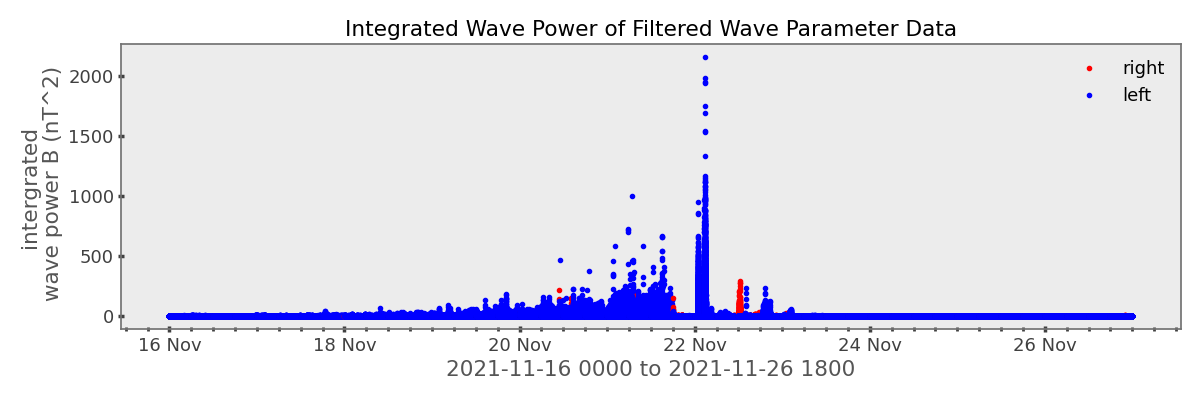

In [95]:
%matplotlib widget
enc10_files = np.sort(glob.glob('Data/filteredActivity_2021-11*.txt'))
fig,ax = plt.subplots(1,1)
fig.set_size_inches((12,4))
colnames =['cdf epoch','lh integrated wave power (nT^2)','rh integrated wave power(nT^2)','lh med ellipticity','rh med ellipticity','lh med coherency','rh med coherency','lh med wave normal angle','rh med wave normal angle']
ax.grid(False) # turns off grid

# read in files and plot integrated wave power
total_epoch = np.array([])

for file in enc10_files:
    test = pd.read_csv(file,delimiter=',',names=colnames)
    date_list = cdflib.cdfepoch.breakdown_epoch(test['cdf epoch'].to_numpy())
    # print(date_list)
    
    
    try: 
        test_epoch = cdfepoch_to_datetime(test['cdf epoch'].to_numpy())
    except:
        print(file)
        continue

    total_epoch = np.concatenate((total_epoch,test_epoch))
    
    rh_int_power = test['rh integrated wave power(nT^2)']
    lh_int_power = test['lh integrated wave power (nT^2)']
    
    ax.plot(test_epoch,rh_int_power,'r.')
    ax.plot(test_epoch,lh_int_power,'b.')
    

# set up labels for plot
    
ax.set_ylabel('intergrated\n wave power B (nT^2)')
ax.legend(['right','left'])
ax.set_title('Integrated Wave Power of Filtered Wave Parameter Data')

# readable date formating 
print(total_epoch)  
ax.xaxis_date('2021-11-16_0000')
date_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)
splot.applySmartTimeTicks(ax, total_epoch, dolimit=False, dolabel=False)
ax.set_xlabel(f"{enc10_files[0].split('_')[1]} {enc10_files[0].split('_')[2].split('.')[0]} to {enc10_files[-1].split('_')[1]} {enc10_files[-1].split('_')[2].split('.')[0]}")
fig.tight_layout()
plt.show()

In [ ]:
# Where is algorithmn doing good and bad
# amplitude^2 (can use \mu_0, perfectly conducting magnetized plasma) --> energy
    # future: flux
            # normalize to background B field (dB/B), stronger magnetic field can fuel larger amplitude waves
# making distribution plots similar to the summer (cut on power for wave activity and bin into minutes)
    # heliocentric distance